# Ad Click Prediction

## Description

The aim of this project is to produce a model that predicts predict user interactions with online ads.

The dataset, sourced from Kaggle, contains 10000 rows and 9 columns, with 8 independent variables and the target variable "click".

### Data Dictionary

|Variable|Description|
|-----|-----|
|id|Unique identifier for each user|
|full_name|User's name formatted as "UserX" for anonymity|
|age|Age of the user (ranging from 18 to 64 years)|
|gender|The gender of the user (categorized as Male, Female, or Non-Binary)|
|device_type|The type of device used by the user when viewing the ad (Mobile, Desktop, Tablet)|
|ad_position|The position of the ad on the webpage (Top, Side, Bottom)|
|browsing_history|The user's browsing activity prior to seeing the ad (Shopping, News, Entertainment, Education, Social Media)|
|time_of_day|The time when the user viewed the ad (Morning, Afternoon, Evening, Night)|
|click|The target label indicating whether the user clicked on the ad (1 for a click, 0 for no click)|

## Import packages

In [121]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.tree import plot_tree

import pickle

## Load dataset

In [240]:
#load dataset
df = pd.read_csv('../Downloads/ad_click_dataset.csv')
df.head()

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


## Data Preprocessing

In [3]:
df.shape

(10000, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.2+ KB


In [164]:
df.describe(include='all')

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
count,10000.000000,10000,5234.000000,5307,8000,8000,5218,8000,10000.000000
unique,NaN,4000,NaN,3,3,3,5,4,NaN
top,NaN,User1171,NaN,Female,Desktop,Bottom,Entertainment,Morning,NaN
freq,NaN,25,NaN,1834,2754,2817,1175,2126,NaN
mean,5060.211400,NaN,40.197363,NaN,NaN,NaN,NaN,NaN,0.650000
std,2861.758265,NaN,13.126420,NaN,NaN,NaN,NaN,NaN,0.476993
min,5.000000,NaN,18.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,2529.000000,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,0.000000
50%,5218.000000,NaN,39.500000,NaN,NaN,NaN,NaN,NaN,1.000000
75%,7466.000000,NaN,52.000000,NaN,NaN,NaN,NaN,NaN,1.000000


## Exploratory data analysis

<AxesSubplot:xlabel='age', ylabel='Count'>

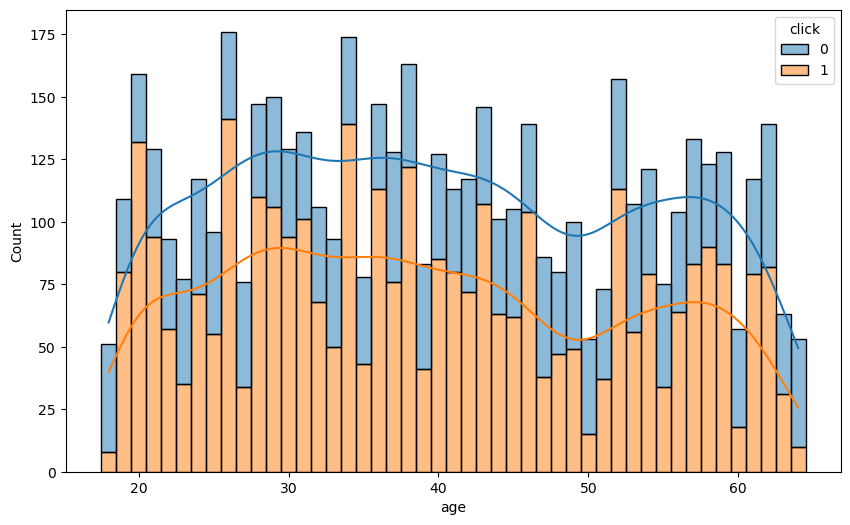

In [315]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='age', hue='click', bins=range(18,65), discrete=True, multiple='stack', kde=True)

Age has a roughly uniform distribiution. There are slighly more ad clicks and data on users aged 20 to 40, and there is a dip in both kde curves around age 50. It is unclear whether this decrease is due to people around age 50 spending less time on the internet or due to the data collection process.

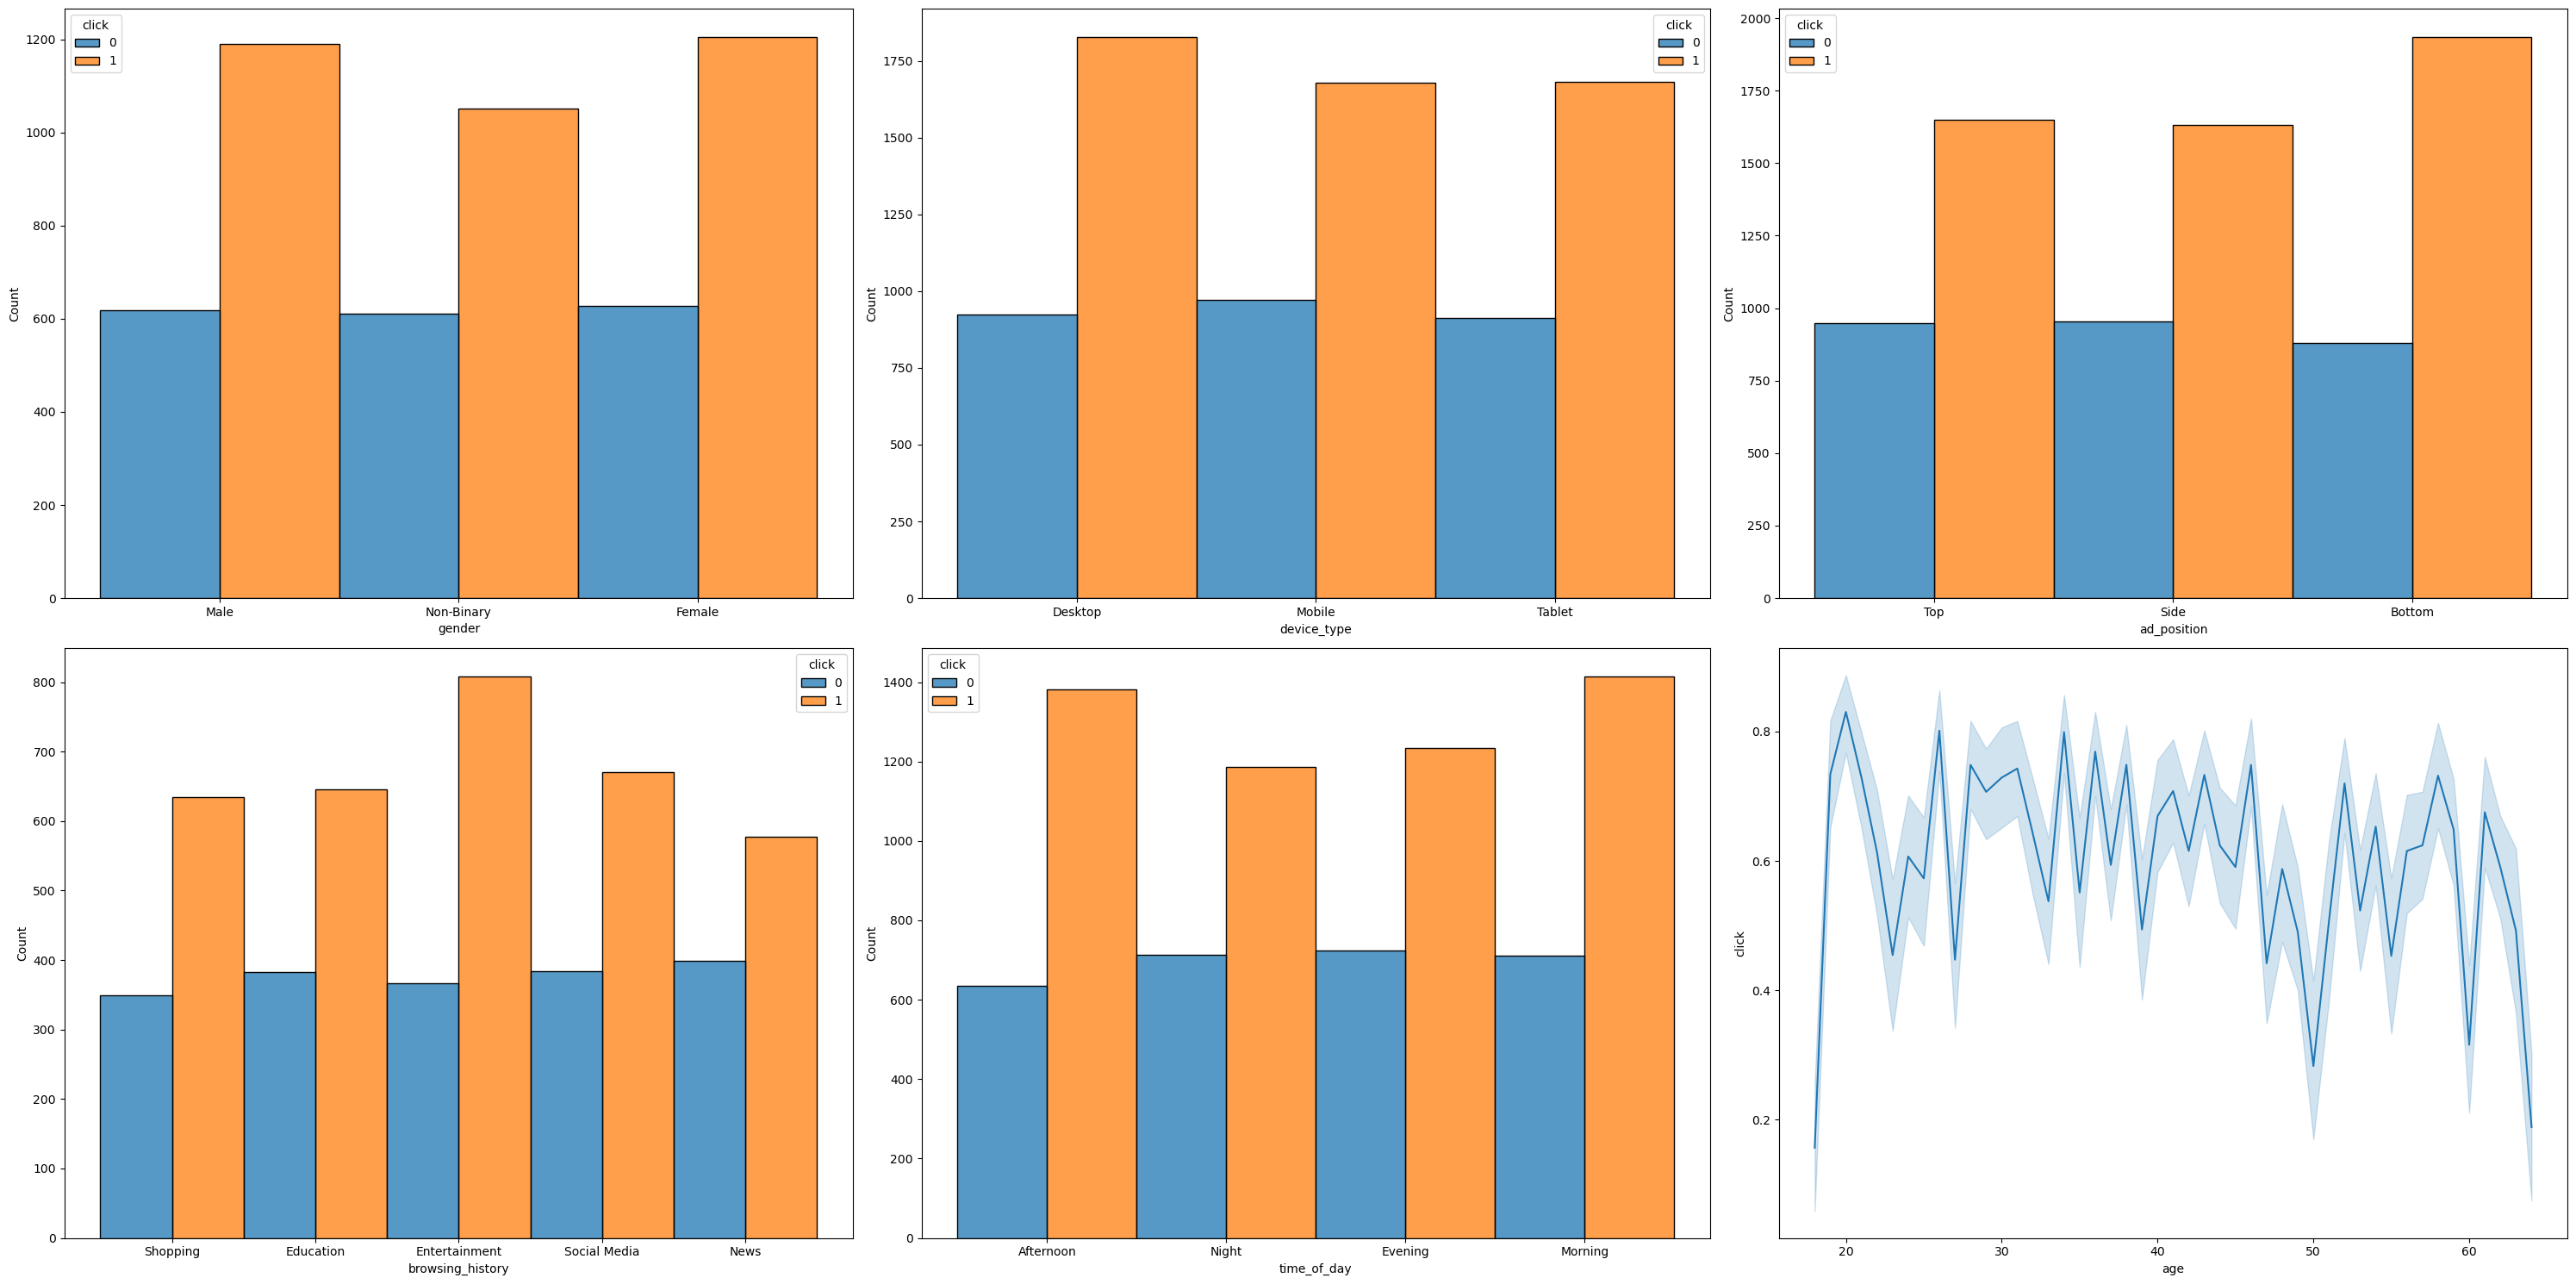

In [316]:
fig, ax = plt.subplots(2, 3, figsize=(30, 15))

sns.histplot(data=df, x='gender', hue='click', multiple='dodge', ax=ax[0][0])
sns.histplot(data=df, x='device_type', hue='click', multiple='dodge', ax=ax[0][1])
sns.histplot(data=df, x='ad_position', hue='click', multiple='dodge', ax=ax[0][2])
sns.histplot(data=df, x='browsing_history', hue='click', multiple='dodge', ax=ax[1][0])
sns.histplot(data=df, x='time_of_day', hue='click', multiple='dodge', ax=ax[1][1])
sns.lineplot(data=df, x='age', y='click', ax=ax[1][2])

plt.tight_layout()

Overall, people tend to click on ads more than not. It appears that ads appearing on the bottom may have higher click-rates, as the ratio of clicks to non-clicks is higher compared to that of ads located at the top or side. Entertainment websites may also yield more clicks as it has the highest click count out of the five browsing history categories. There may also be an increased tendency to click on ads in the afternoon as afternoon and morning have a higher number of clicks, but afternoon time has a lower number of non-clicks.

## Model Construction

In [321]:
df_final = df.copy()

In [322]:
df_final[df_final.duplicated(keep=False)]

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
8,7993,User7993,NaN,Non-Binary,Mobile,Bottom,Social Media,NaN,1
9,4509,User4509,NaN,NaN,NaN,Bottom,Education,Afternoon,1
10,2595,User2595,NaN,NaN,NaN,Bottom,NaN,Morning,1
...,...,...,...,...,...,...,...,...,...
9981,7808,User7808,26.0,Female,Desktop,Top,NaN,Night,1
9984,9422,User9422,21.0,NaN,NaN,Side,Entertainment,Night,1
9985,8994,User8994,34.0,NaN,Mobile,Bottom,Entertainment,Morning,1
9986,5574,User5574,52.0,Female,Desktop,Bottom,Shopping,Afternoon,1


In [323]:
#backfill null values
df_final=df_final.sort_values(by='id', axis=0, ascending=True, ignore_index=True)
df_final = df_final.fillna(method='bfill')

In [324]:
df_final.isna().sum()

id                  0
full_name           0
age                 0
gender              0
device_type         0
ad_position         0
browsing_history    0
time_of_day         0
click               0
dtype: int64

In [325]:
#variable selection
X = df_final.drop(['id', 'full_name', 'click'], axis=1)
y = df_final['click']

In [326]:
#encode non-numerical columns
X = pd.get_dummies(data=X, drop_first=True)
X.head()

,age,gender_Male,gender_Non-Binary,device_type_Mobile,device_type_Tablet,ad_position_Side,ad_position_Top,browsing_history_Entertainment,browsing_history_News,browsing_history_Shopping,browsing_history_Social Media,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
0,24.0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,24.0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,24.0,0,0,0,1,0,0,0,0,1,0,1,0,0
3,24.0,0,0,0,1,0,0,0,0,1,0,1,0,0
4,24.0,0,0,0,1,0,0,0,0,1,0,1,0,0


In [327]:
y.value_counts(normalize=True)

1    0.65
0    0.35
Name: click, dtype: float64

In [328]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7000, 14) (3000, 14) (7000,) (3000,)


### Logistic Regression

In [329]:
clf = LogisticRegression(random_state=0, max_iter=500)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=0)

In [330]:
y_pred_log = clf.predict(X_test)

In [331]:
#save logistic regression evaluation metrics
log_results = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Accuracy': [accuracy_score(y_test, y_pred_log)],
    'Precision': [precision_score(y_test, y_pred_log)],
    'Recall': [recall_score(y_test, y_pred_log)],
    'F1': [f1_score(y_test, y_pred_log)],
    'Roc Auc': [roc_auc_score(y_test, y_pred_log)]
})
log_results

,Model,Accuracy,Precision,Recall,F1,Roc Auc
0,Logistic Regression,0.651333,0.650868,1.0,0.788516,0.501905


### Decision Tree

In [332]:
#create decision tree with hyperparameter tuning
tree = DecisionTreeClassifier(random_state=42)
cv_params = {'max_depth': [4, 6, 8, None],
             'min_samples_split': [2, 4, 6],
             'min_samples_leaf': [1, 3, 5]}

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=5, refit='f1')

In [333]:
%%time

tree1.fit(X_train, y_train)

CPU times: user 2.66 s, sys: 28.1 ms, total: 2.68 s
Wall time: 2.7 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 4, 6]},
             refit='f1',
             scoring={'precision', 'recall', 'roc_auc', 'f1', 'accuracy'})

In [334]:
tree1.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [335]:
#use best parameters to train decision tree on entire training data sets
tree2 = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
tree2.fit(X_train, y_train)
y_pred_tree = tree2.predict(X_test)

In [336]:
#save decision tree evaluation metrics
tree_results = pd.DataFrame({
    'Model': ['Decision Tree'],
    'Accuracy': [accuracy_score(y_test, y_pred_tree)],
    'Precision': [precision_score(y_test, y_pred_tree)],
    'Recall': [recall_score(y_test, y_pred_tree)],
    'F1': [f1_score(y_test, y_pred_tree)],
    'Roc Auc': [roc_auc_score(y_test, y_pred_tree)]
})
tree_results

,Model,Accuracy,Precision,Recall,F1,Roc Auc
0,Decision Tree,0.906,0.890084,0.975897,0.931018,0.876044


### Random Forest

In [269]:
#create random forest model with hyperparameter tuning
rf = RandomForestClassifier(random_state=42)

cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [100, 300],
             }

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')

In [270]:
%%time

rf1.fit(X_train, y_train)

CPU times: user 8min 42s, sys: 6.77 s, total: 8min 49s
Wall time: 8min 50s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 300]},
             refit='f1',
             scoring={'precision', 'recall', 'roc_auc', 'f1', 'accuracy'})

In [271]:
with open('ad_click_rf.pickle', 'wb') as to_write:
    pickle.dump(rf1, to_write)

In [272]:
with open('ad_click_rf.pickle', 'rb') as to_read:
    rf1 = pickle.load(to_read)

In [273]:
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [274]:
#use best parameters to train random forest model on entire training data sets
rf2 = RandomForestClassifier(max_depth=None, max_features=1.0,
                            max_samples=1.0, min_samples_leaf=1,
                            min_samples_split=2, n_estimators=300,
                            random_state=42)
rf2.fit(X_train, y_train)
y_pred_rf = rf2.predict(X_test)

In [275]:
#save random forest evaluation metrics
rf_results=pd.DataFrame({
    'Model': ['Random Forest'],
    'Accuracy': [accuracy_score(y_test, y_pred_rf)],
    'Precision': [precision_score(y_test, y_pred_rf)],
    'Recall': [recall_score(y_test, y_pred_rf)],
    'F1': [f1_score(y_test, y_pred_rf)],
    'Roc Auc': [roc_auc_score(y_test, y_pred_rf)]
})
rf_results

,Model,Accuracy,Precision,Recall,F1,Roc Auc
0,Random Forest,0.919,0.910139,0.971282,0.939717,0.896593


## Model Evaluation

### Confusion Matrix

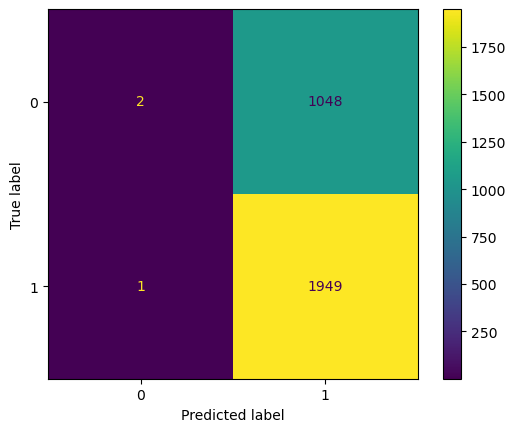

In [276]:
#plot confusion matrix for logistic regression
cm = confusion_matrix(y_test, y_pred_log, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)
disp.plot()

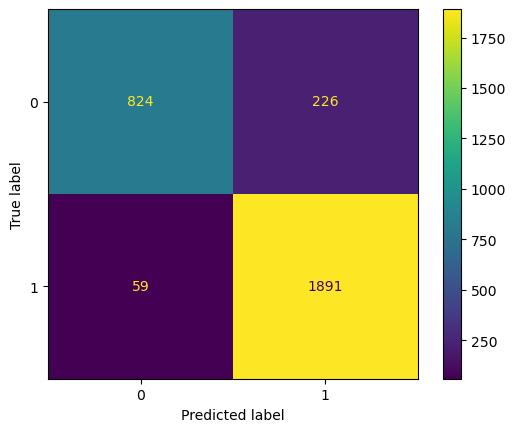

In [277]:
#plot confusion matrix for decision tree
cm = confusion_matrix(y_test, y_pred_tree, labels=tree2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tree2.classes_)
disp.plot()

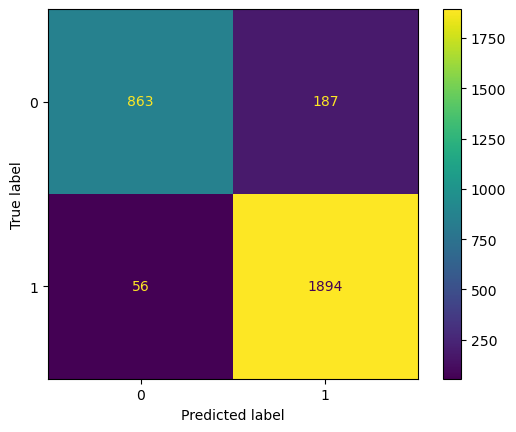

In [278]:
#plot confusion matrix for random forest
cm = confusion_matrix(y_test, y_pred_rf, labels=rf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf2.classes_)
disp.plot()

### Classification Reports

In [342]:
print('Logistic Regression:\n', classification_report(y_test, y_pred_log))
print('Decision Tree:\n', classification_report(y_test, y_pred_tree))
print('Random Forest:\n', classification_report(y_test, y_pred_rf))

Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.00      0.01      1050
           1       0.65      1.00      0.79      1950

    accuracy                           0.65      3000
   macro avg       0.83      0.50      0.40      3000
weighted avg       0.77      0.65      0.52      3000

Decision Tree:
               precision    recall  f1-score   support

           0       0.95      0.78      0.85      1050
           1       0.89      0.98      0.93      1950

    accuracy                           0.91      3000
   macro avg       0.92      0.88      0.89      3000
weighted avg       0.91      0.91      0.90      3000

Random Forest:
               precision    recall  f1-score   support

           0       0.94      0.82      0.88      1050
           1       0.91      0.97      0.94      1950

    accuracy                           0.92      3000
   macro avg       0.92      0.90      0.91      3000
weighted avg       0

### Evaluation Metrics

In [282]:
#create table of evaluation metrics
results = pd.concat([log_results, tree_results, rf_results], axis=0).reset_index(drop=True)
results

,Model,Accuracy,Precision,Recall,F1,Roc Auc
0,Logistic Regression,0.650333,0.650317,0.999487,0.787952,0.500696
1,Decision Tree,0.905000,0.893245,0.969744,0.929924,0.877253
2,Random Forest,0.919000,0.910139,0.971282,0.939717,0.896593


The random forest and the decision tree performed significantly better than the logistic regression model. The random forest model had slightly better scores than the decision tree. 

### Feature Importances

In [343]:
#extract and sort feature importances
tree_importances = pd.DataFrame(tree2.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree_importances = tree_importances.sort_values(by='gini_importance', ascending=False)

In [344]:
rf_importances = pd.DataFrame(rf2.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
rf_importances = rf_importances.sort_values(by='gini_importance', ascending=False)

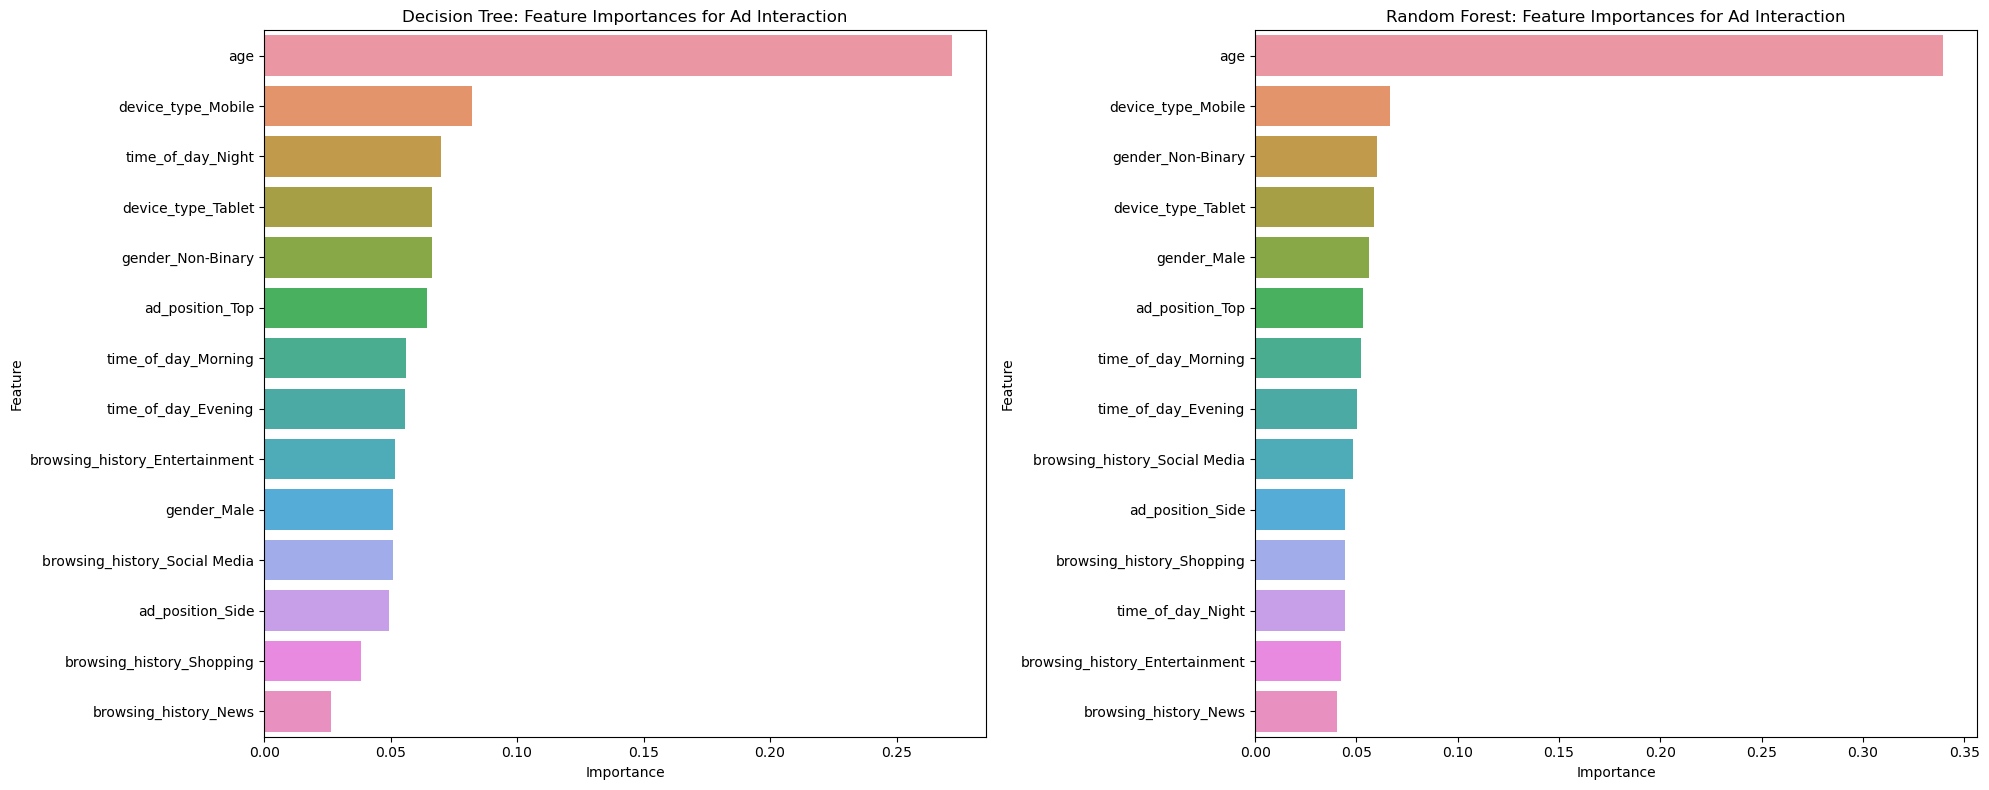

In [345]:
#plot feature importances
fig, ax = plt.subplots(1, 2, figsize=(20,8))

sns.barplot(data=tree_importances, x="gini_importance", y=tree_importances.index, orient='h', ax=ax[0])
ax[0].set_title("Decision Tree: Feature Importances for Ad Interaction", fontsize=12)
ax[0].set_ylabel("Feature")
ax[0].set_xlabel("Importance")

sns.barplot(data=rf_importances, x="gini_importance", y=rf_importances.index, orient='h', ax=ax[1])
ax[1].set_title("Random Forest: Feature Importances for Ad Interaction", fontsize=12)
ax[1].set_ylabel("Feature")
ax[1].set_xlabel("Importance")

plt.tight_layout()

Age is the most important feature in predicting whether a person will click on an ad. Ad position does not seem to have a significant effect on ad interaction, suggesting that it is more useful for advertisers to focus on demographics and appeal to audiences to increase ad interaction.

## Conclusion

The random forest model produced the most accurate results in predicting ad interaction. Age seems to be an important predictor in whether a user clicks on an ad, which could be related to the type of ad shown. A product or service might only appeal to people of certain ages, which would influence the number of clicks from a particular demographic. 

It is important to take into account that the dataset does not indicate what kind of product/service was ad was shown during data collection. Increasing ad clicks entails understanding and marketing to the target demographic of the product/service. Thus, further analysis on the interests of each age group would better explain a person's tendency to click on an ad.